<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
import pathlib
current_dir = pathlib.Path.cwd()
parent_dir = current_dir.parent
preprocessing_output_dir = pathlib.Path('{}/1_preprocessing_all_domain/output'.format(parent_dir))
output_dir = pathlib.Path('{}/output'.format(current_dir))
pathlib.Path.mkdir(output_dir, mode=0o777, exist_ok=True)
print(current_dir)

d:\GIT_CODE\CDM_LSTM\3_time_series_classification


In [61]:
with open('{}/0_importsql/abnormal_list.txt'.format(parent_dir), 'r') as f:
    data = f.read()
outcome_name_list = data.splitlines()

In [62]:
def split_x_y_data(df, OBP) :
    import numpy as np
    import pandas as pd

    y_data = df['label'].T.reset_index(drop=True) #df['label'].T.drop_duplicates().T.reset_index(drop=True)
    y_data = np.array(y_data)
    y_data = y_data[0:len(y_data):OBP].reshape(-1, 1).astype(int)
    #print(len(y_data), file=_logfile_)

    x_df = df.drop('label', axis=1)

    # 2-d data to 3-d data
    timestamp = OBP 
    x_data = np.array(x_df)
    x_data = x_data.reshape(-1, timestamp, x_data.shape[1]) # -1(sample), timestamp, column
    #x_data.shape, y_data.shape

    # get Column data
    new_col = x_df.columns
    print(x_data.shape, y_data.shape, len(new_col))
    return x_data, y_data, new_col

In [63]:
import os
import pickle
from tqdm import tqdm
from Auto_lstm_attention import *
c = Auto_lstm_attention()

outcome_name = outcome_name_list[0]
# 결과물 저장할 폴더 생성
output_domain_path = pathlib.Path('{}/{}'.format(output_dir, outcome_name))
pathlib.Path.mkdir(output_domain_path, mode=0o777, parents=True, exist_ok=True)
        
concat_df = pd.read_csv('{}/{}.txt'.format(preprocessing_output_dir, outcome_name), index_col=False)

# ##### Case 1 : Split by subject_id #####
# id_data = concat_df[['subject_id', 'label']].drop_duplicates().reset_index(drop=True)
# x_id_data = np.array(id_data['subject_id'])
# y_id_data = np.array(id_data['label'])

# x_id_train, x_id_test, y_id_train, y_id_test = train_test_split(x_id_data, y_id_data, test_size=0.3, random_state=1, stratify=y_id_data) 

# train_df = concat_df[concat_df['subject_id'].isin(x_id_train)].reset_index(drop=True)
# test_df = concat_df[concat_df['subject_id'].isin(x_id_test)].reset_index(drop=True)

# train_df.to_csv('{}/{}_train.txt'.format(output_domain_path, outcome_name), index=False)
# test_df.to_csv('{}/{}_test.txt'.format(output_domain_path, outcome_name), index=False)

# concat_df = concat_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
# train_df = train_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
# test_df = test_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)

# x_data, y_data, new_col = split_x_y_data(concat_df, OBP=28)
# x_train, y_train, new_col = split_x_y_data(train_df, OBP=28)
# x_test, y_test, new_col = split_x_y_data(test_df, OBP=28)

#### Case 2 : Split ignore subject_id #####
concat_df = concat_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
x_data, y_data, new_col = split_x_y_data(concat_df, OBP=28)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, stratify=y_data) 


(2701, 28, 83) (2701, 1) 83


In [ ]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
# stable = False # True: stable version in pip, False: latest version from github
# if stable: 
#     !pip install tsai -U >> /dev/null
# else:      
#     !pip install git+https://github.com/timeseriesAI/tsai.git -U >> /dev/null
# ## NOTE: REMEMBER TO RESTART (NOT RECONNECT/ RESET) THE KERNEL/ RUNTIME ONCE THE INSTALLATION IS FINISHED

In [64]:
from tsai.all import*

In [65]:
computer_setup()

os             : Windows-10-10.0.17134-SP0
python         : 3.7.8
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.10.0+cpu
n_cpus         : 6
device         : cpu


In [ ]:
X_train, y_train, X_test, y_test  = get_UCR_data(dsid, return_split=True)

you can use this convenience function to get X, y and splits:

In [66]:
splits

((#180) [0,1,2,3,4,5,6,7,8,9...],
 (#180) [180,181,182,183,184,185,186,187,188,189...])

In [67]:
x, y, splits = combine_split_data([x_train, x_test], [y_train, y_test])

In [68]:
y.shape

(2701, 1)

### Prepare datasets ??

The first step is to create datasets. This is very easy to do in v2. 

In TS classification problems, you will usually want to use an item tfm to transform y into categories.

We'll use inplace=True to preprocess data at dataset initialization. This will significantly speed up training. 

In [69]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(x, y.flatten(), tfms=tfms, splits=splits, inplace=True)

We'll now build the dataloaders that will create batches of data.

You will need to pass:

* datasets: usually 2 - train and valid -  or 1 - test or unlabeled- depending on the problem
* batch size(s): you may pass a single value (will will be appied to all dls, or different values, one for each dl.
* batch_tfms (same as after_batch): you may decide to pass some tfms at the batch level. In this case for example, we'll standardize the data (0 mean and 1 std). You may get more details on how these transforms work in the transforms nb.
* num workers: num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process. This will depend on your machine, dataset, etc. You may want to start with 0, and test other values to see how to train faster. For me, 0 works better.

In [70]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[32, 64], batch_tfms=[TSStandardize()], num_workers=0)

### Visualize data

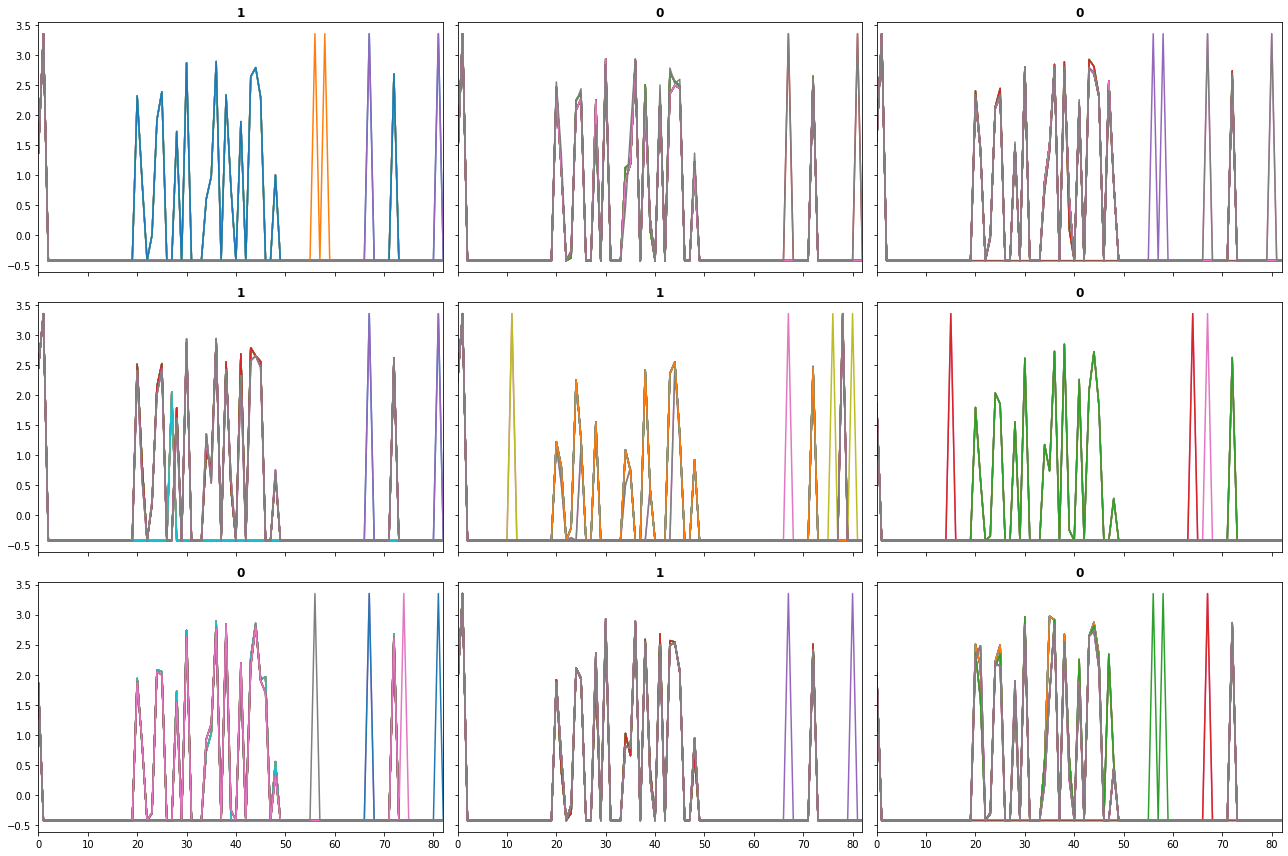

In [71]:
dls.show_batch(sharey=True)

## Build learner ??

In [74]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

## Train model ?????

### LR find ??

SuggestedLRs(valley=0.001737800776027143)

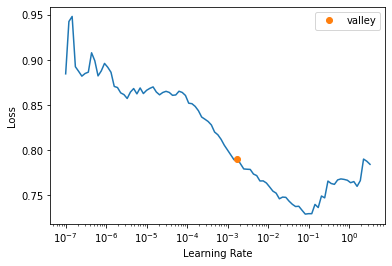

In [77]:
learn.load('stage0')
learn.lr_find()
#learn.lr_find(suggestions=False)

### Train ?????��?

In [78]:
learn.fit_one_cycle(25, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.712171,0.638489,0.641184,00:12
1,0.618074,0.597198,0.659679,00:11
2,0.554693,0.793812,0.654747,00:11
3,0.532222,0.554339,0.718866,00:12
4,0.496827,0.542569,0.728730,00:12
5,0.489175,0.545967,0.710234,00:13
6,0.460897,0.574277,0.712700,00:09
7,0.435595,0.799492,0.676942,00:09
8,0.394252,0.554916,0.752158,00:10
9,0.360909,0.601385,0.728730,00:12


Path('models/stage1.pth')

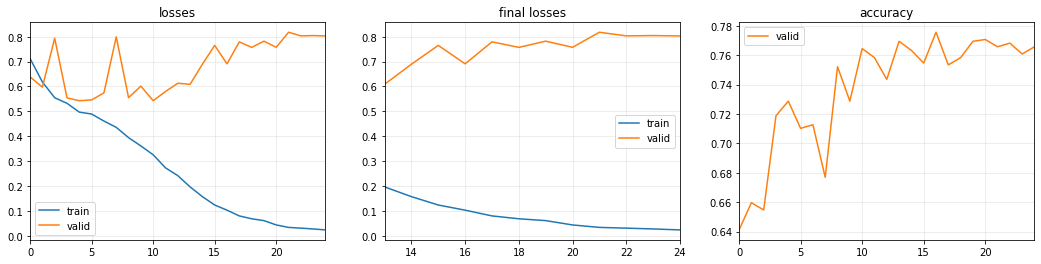

In [79]:
learn.recorder.plot_metrics()

Let's pretend we need to end the working session now for some reason, but we'd like to continue working with this datasets and learner in the future. 

To save everything you can use a convenience function I've created that saves the learner with the model, the data and the opt function status: 

In [80]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


As soon as we've done this, we can end the session, and continue at any time in the future. 

Let's simulate that we need to end the session now:

In [81]:
del learn, dsets, dls

Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

In [82]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:64, vars:28, len:83, device=cpu),
 TensorCategory([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]))

In [83]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(TensorBase([[4.4520e-02, 9.5548e-01],
         [6.6891e-03, 9.9331e-01],
         [8.8658e-02, 9.1134e-01],
         ...,
         [6.4468e-02, 9.3553e-01],
         [7.1432e-02, 9.2857e-01],
         [3.1181e-04, 9.9969e-01]]),
 TensorCategory([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
         0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
         1, 1, 0, 1, 0, 1, 1, 0, 

We can confirm the learner has the same status it had at the end of training, by confirming the validation accuracy is the same:

In [84]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.7657)

Great! It's the same. This means we have now the learner at the same point where we left it.

## Visualize results ??

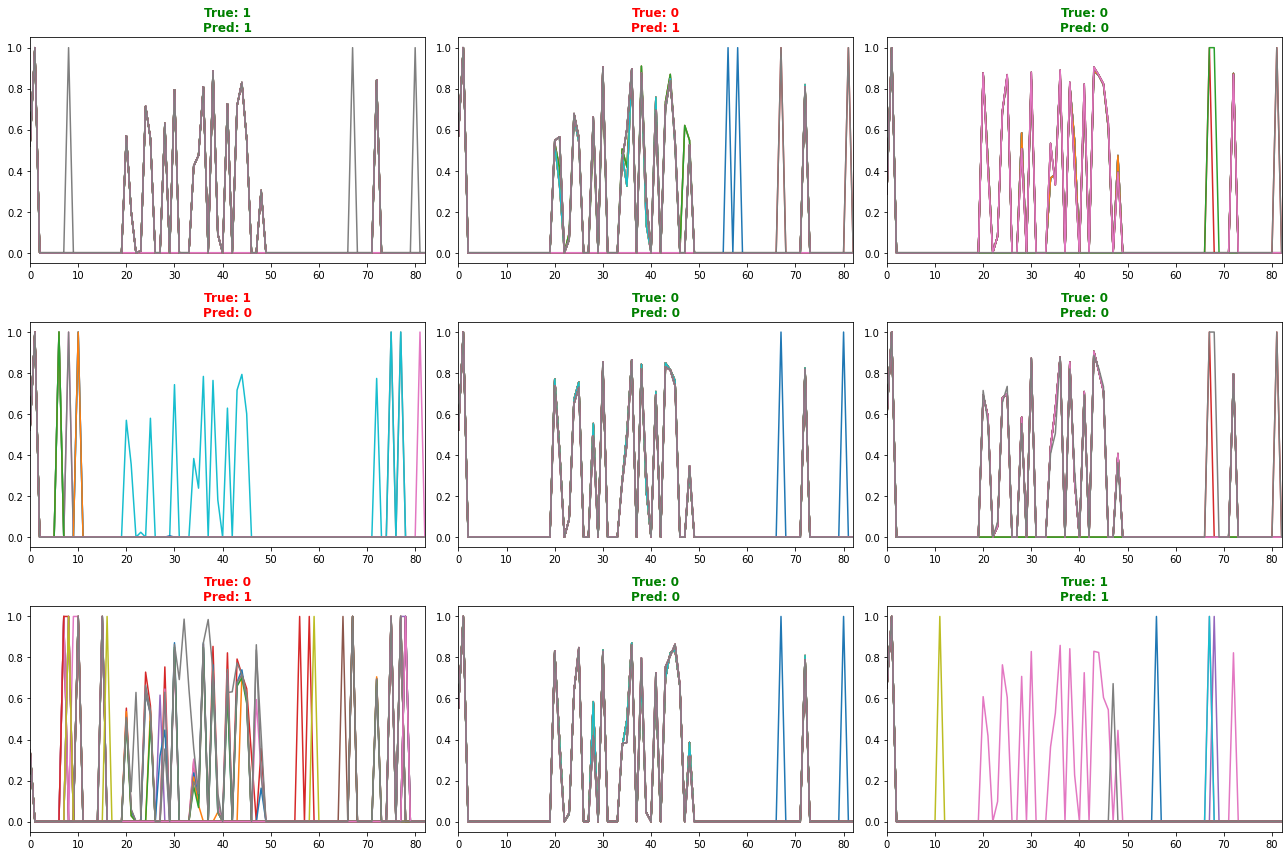

In [85]:
learn.show_results()

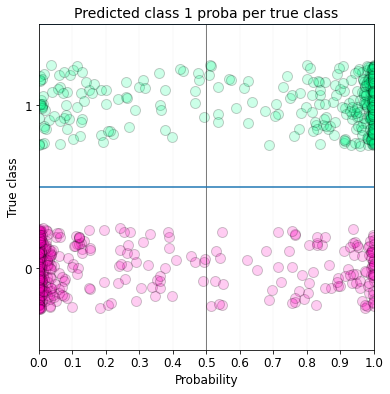

In [86]:
learn.show_probas()

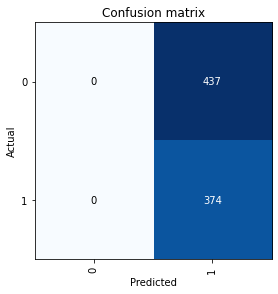

In [87]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [88]:
interp.most_confused(min_val=3)

[(0, 1, 437)]

## Inference on additional data ??

Let's say we want to predict labels on new data. Let's see how this works.

We may have additional data (test set) where we want to check our performance. In this case, we'd add a labeled dataset:

In [89]:
# Labeled test data
test_ds = valid_dl.dataset.add_test(x, y.flatten())# In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:64, vars:28, len:83, device=cpu),
 TensorCategory([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
         1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]))

By selecting the valid dataset (valid_dl.dataset) we ensure that the same tfms applied to the valid data will be applied to the new data.

In [90]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(TensorBase([[0.0050, 0.9950],
         [0.0037, 0.9963],
         [0.0055, 0.9945],
         ...,
         [0.0015, 0.9985],
         [0.0020, 0.9980],
         [0.0032, 0.9968]]),
 TensorCategory([0, 1, 0,  ..., 1, 1, 1]),
 TensorBase([1, 1, 1,  ..., 1, 1, 1]))

In [91]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.461681


If data is unlabeled, we'd just do this: 

In [93]:
# Unlabeled data
test_ds = dls.dataset.add_test(x)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:64, vars:28, len:83, device=cpu),)

In [94]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

TensorBase([[0.0050, 0.9950],
        [0.0037, 0.9963],
        [0.0055, 0.9945],
        ...,
        [0.0015, 0.9985],
        [0.0020, 0.9980],
        [0.0032, 0.9968]])

## Summary ?

This is all the code you need to train a TS model. As you can see, it's v2 is easier to use and faster compared to v1.

epoch,train_loss,valid_loss,accuracy,time
0,1.967492,1.817641,0.133333,00:00
1,1.894808,1.814099,0.150000,00:00
2,1.741195,1.806358,0.205556,00:00
3,1.573634,1.789628,0.227778,00:00
4,1.402324,1.753968,0.272222,00:00
5,1.248038,1.687042,0.350000,00:00
6,1.120863,1.565439,0.605556,00:00
7,1.019557,1.404674,0.666667,00:00
8,0.929989,1.204971,0.677778,00:00
9,0.853835,0.990172,0.800000,00:00


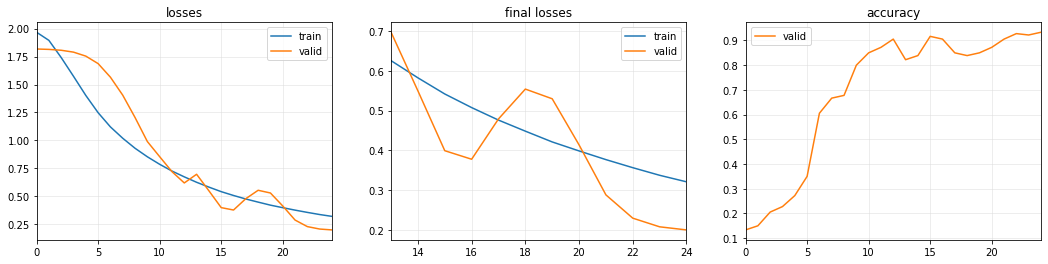

In [95]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()

## New scikit-learn-like API ??

As of `tsai` version 0.2.15 I have added a new scikit-learn-like API to further simplify the learner creation. 

I will prepare a new tutorial to further demonstrate how you can use the new API.

This is how you can use it for Time Series Classification: 

epoch,train_loss,valid_loss,accuracy,time
0,1.950792,1.832381,0.127778,00:00
1,1.851009,1.819222,0.127778,00:00
2,1.683752,1.803457,0.144444,00:00
3,1.511847,1.778563,0.211111,00:00
4,1.344290,1.734831,0.305556,00:00
5,1.186986,1.650455,0.572222,00:00
6,1.066000,1.517141,0.650000,00:00
7,0.969655,1.345964,0.683333,00:00
8,0.886274,1.158084,0.744444,00:00
9,0.812390,0.972392,0.855556,00:00


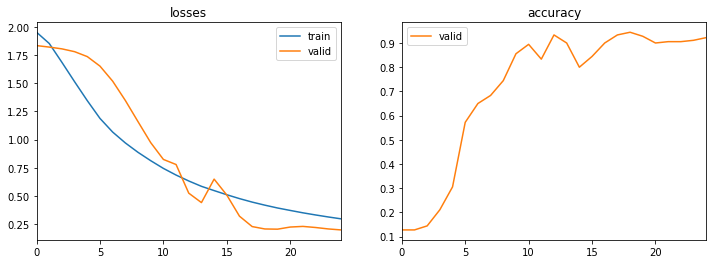

In [ ]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=[TSStandardize()], arch=InceptionTime, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()